# Clustering de Logs de Ciberataques


Este cuaderno Jupyter está diseñado para explorar y analizar un conjunto de datos que contiene logs asociados a la simulación de ciberataques. El objetivo principal es identificar patrones y agrupaciones de comportamientos maliciosos utilizando diversas técnicas de procesamiento de texto, reducción de dimensionalidad y clustering.

## Metodología

El análisis se llevará a cabo en varias etapas clave:

1.  **Preprocesamiento de Datos**: Limpiar y preparar los logs para el análisis como la normalización de texto y generación de nuevas columnas.

2.  **Vectorización de Texto**: Transformar los mensajes de log en representaciones numéricas que pueden ser procesadas por algoritmos de aprendizaje automático. Exploraremos herramientas como:

      - TF-IDF (Term Frequency-Inverse Document Frequency) solo y también usando TfidfVectorizer de la biblioteca sklearn, que ayuda a convertir el texto en una matriz de características TF-IDF.
      - PROPUESTA DE MEJORA: probar el funcionamiento con Word2Vec y BERT (Bidirectional Encoder Representations from Transformers)

3.  **Reducción de Dimensionalidad**: Dado que las representaciones vectoriales del texto pueden ser de alta dimensión, utilizaremos técnicas como PCA (Análisis de Componentes Principales) y t-SNE (t-Distributed Stochastic Neighbor Embedding) para reducir la cantidad de dimensiones y simplificar los datos sin perder información crítica.

4.  **Clustering**: Aplicar y comparar varios algoritmos de clustering, incluyendo K-Means, DBSCAN, Clustering Jerárquico y Clustering Jerárquico Aglomerativo. Posteriormente, evaluar la efectividad de cada algoritmo para agrupar los datos de logs de manera significativa.

5.  **Análisis Comparativo**: Utilizar varias métricas de evaluación como el coeficiente de silueta, el índice de Davies-Bouldin y el índice de Calinski-Harabasz para comparar los resultados de los diferentes algoritmos de clustering.
Interpretar los clusters formados y discutir los insights relevantes que podrían ayudar en la detección proactiva de amenazas en sistemas Linux.

# Extracción de características con TF-IDF

Para vectorizar el texto y extraer características de este se usa TF-IDF:
  - **Term Frequency (TF)**: Esta parte mide la frecuencia de una palabra en un documento particular. Por lo que vectoriza el texto convirtiendo las palabras en un conjunto de números que representan la frecuencia de cada palabra dentro de un documento individual.

  - **Inverse Document Frequency (IDF)**: Reduce la escala de las palabras que aparecen muy frecuentemente en el conjunto de documentos (corpus) y que, por lo tanto, son menos informativas o discriminativas. Es una forma de extracción de características porque ayuda a resaltar las palabras que son más únicas para cada documento.

La combinación de TF e IDF en el vector TF-IDF permite tanto la vectorización del texto (convirtiéndolo en un formato numérico que las máquinas pueden procesar) como la extracción de características (destacando la importancia relativa de las palabras dentro de los documentos en el corpus).

Ayuda a reducir el ruido puesto que las palabras muy comunes que no aportan mucho valor para la diferenciación entre documentos obtienen un peso menor.

Resalta los términos relevantes: Destaca las palabras más raras y específicas poniéndoles un peso mayor.

Convierte los textos en vectores para usar directamente en los algoritmos de clustering (y en lo que se quiera pero nos interesa el clustering).

In [8]:
!pip install umap-learn

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.manifold import trustworthiness
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import pairwise_distances
from sklearn.metrics import calinski_harabasz_score
from tabulate import tabulate
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import squareform, pdist

In [10]:
# Cargar el dataset especificando el delimitador de tabulación
data = pd.read_csv('05_Synthetic-logs-5k.csv', delimiter='\t')

# Mostrar las primeras filas del dataframe para verificar que todo está correcto
print(data.head())

# Extracción de características usando TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['Message'])
features = vectorizer.get_feature_names_out()

# Comprobar las dimensiones de los datos originales
n_samples, n_features = X.shape
print(f'Número de documentos (n_samples): {n_samples}')
print(f'Número de características (n_features): {n_features}')


   YYYY  MM  DD  hh:mm  Hostname    Service  User         Source     IP  \
0  2024   2   3  09:41   server9   ftp[94]:  root    192.168.2.1   2679   
1  2024  11  30  08:18  server20  sshd[54]:  root  192.168.3.151  56670   
2  2024   3  31  19:43  server19  sshd[58]:  root    192.168.1.1  42011   
3  2024  12  22  22:18   server4    su[99]:  test  192.168.3.151  30177   
4  2024   3  10  15:51  server13    su[52]:  test    192.168.3.1  32754   

      Port  ... Interface     UID Action     Protocol Component Severity  \
0    error  ...      1001  failed    UDP  application      high  warning   
1    error  ...      1000    open   ICMP       system      high    error   
2  warning  ...      1001  failed   ICMP      network      high  warning   
3  session  ...         0   close    TCP      network    medium     info   
4    error  ...      1000  failed   ICMP       system    medium  warning   

   Type    Thread           ID  \
0  1033      ftp:   connection   
1  2736  Possible       

Algoritmo del codo para determinar el número de clusters:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


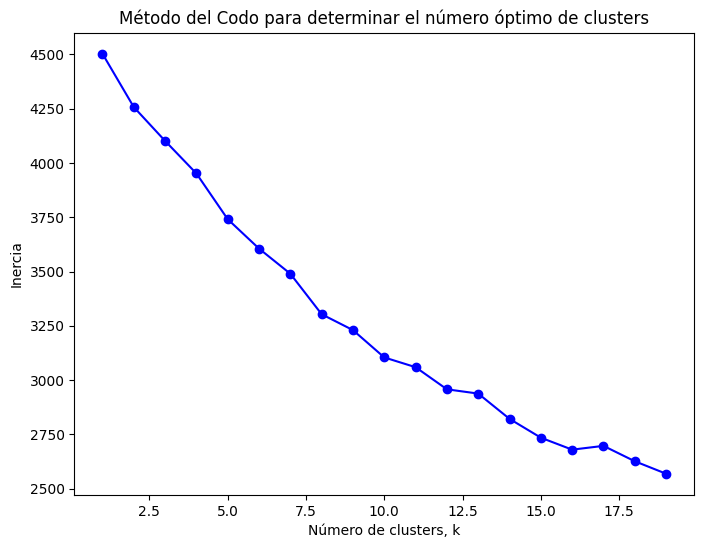

In [11]:
# Calcular la inercia para diferentes valores de k
inertias = []
K = range(1, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Número de clusters, k')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

Según esa gráfica se puede pensar que hay tres codos, uno al rededor de 5 clusters, otro al rededor de 10 y otro entre 15 y 17.5. Por esto se va a utilizar el valor del silhouette score según el número de clusters para ver cuál sería el número óptimo.

Para n_clusters = 2, el Silhouette Score promedio es: 0.05399465622830646


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 3, el Silhouette Score promedio es: 0.0671423185277116


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 4, el Silhouette Score promedio es: 0.06815938007506715


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 5, el Silhouette Score promedio es: 0.10230390362140247


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 6, el Silhouette Score promedio es: 0.11429129585840962


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 7, el Silhouette Score promedio es: 0.12358055904156069


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 8, el Silhouette Score promedio es: 0.1468832337128868


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 9, el Silhouette Score promedio es: 0.15835169678412217


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 10, el Silhouette Score promedio es: 0.18367467388823563


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 11, el Silhouette Score promedio es: 0.17881066894630304


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 12, el Silhouette Score promedio es: 0.18554047397909412


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 13, el Silhouette Score promedio es: 0.1646094248006701


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 14, el Silhouette Score promedio es: 0.19443824402287482


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 15, el Silhouette Score promedio es: 0.1962457322474952


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 16, el Silhouette Score promedio es: 0.1935185047611385


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 17, el Silhouette Score promedio es: 0.18836312113339285


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 18, el Silhouette Score promedio es: 0.2049852563511274


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 19, el Silhouette Score promedio es: 0.2135678611879889


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 20, el Silhouette Score promedio es: 0.2060471630762856


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 21, el Silhouette Score promedio es: 0.20396487194430893


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 22, el Silhouette Score promedio es: 0.21565873328037982


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 23, el Silhouette Score promedio es: 0.22297324096903098


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 24, el Silhouette Score promedio es: 0.21730537473585568


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 25, el Silhouette Score promedio es: 0.223698077451668


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 26, el Silhouette Score promedio es: 0.2278573949168048


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 27, el Silhouette Score promedio es: 0.2106678856829209


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 28, el Silhouette Score promedio es: 0.21556005790628524


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 29, el Silhouette Score promedio es: 0.2138112249423329


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 30, el Silhouette Score promedio es: 0.23784627965581975


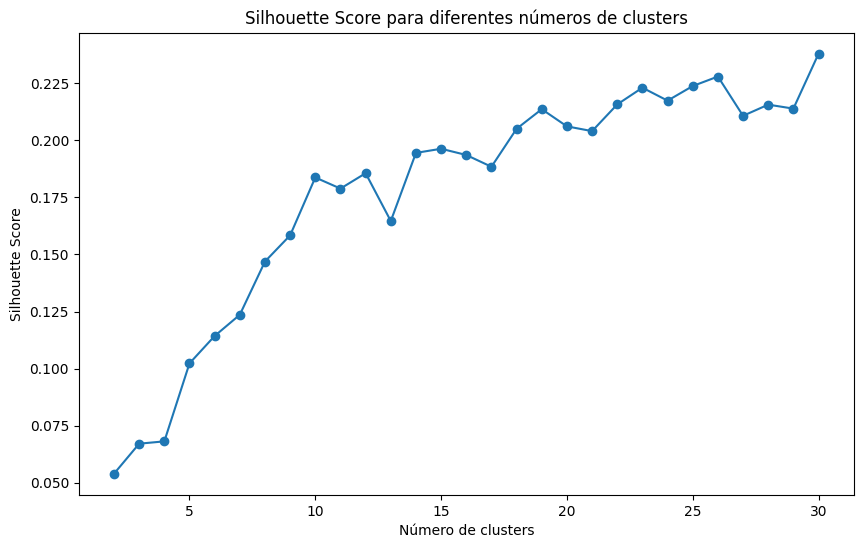

In [12]:
# Rango de clústeres a probar
range_n_clusters = range(2, 31)

# Almacenar los Silhouette Scores para cada número de clústeres
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Calcular el Silhouette Score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Para n_clusters = {n_clusters}, el Silhouette Score promedio es: {silhouette_avg}')

# Graficar los Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes números de clusters')
plt.show()


Como podemos observar, la gráfica tiene forma ascendente, no se observa ningún pico significativo que indique que ese es el número óptimo de clusters. Los valores que ha tomado el silhouette score para los 30 clusters que se han establecido son muy pequeños, esto se debe a que todos los logs son diferentes, incluso los de fuerza bruta porque el timestamp varía. Por ello, el silhouette score va a detectar cada uno como un cluster diferente por lo que si seguimos aumentando el número de clusters en la gráfica el valor va a ir creciendo poco a poco, por lo que se tiene que poner un número de clusters más o menos realista. Es por esto que se ha decidido establecer el número de clusters a 10.

Funciones para extraer las palabras clave de cada cluster y pintarlas debajo de la gráfica:

In [13]:
# Función para extraer palabras clave por cluster
def extract_cluster_terms(labels, features, X, n_words=10):
    unique_labels = np.unique(labels)
    cluster_terms = {}
    for label in unique_labels:
        if label != -1:  # Excluir clusters marcados como ruido por DBSCAN
            indices = np.where(labels == label)[0]
            if len(indices) > 0:
                cluster_data = X[indices]
                centroid = np.mean(cluster_data, axis=0).flatten()
                top_indices = np.argsort(-centroid)[:n_words]
                cluster_terms[label] = [features[i] for i in top_indices]
    return cluster_terms

# Función para pintar y mostrar términos de cluster
def plot_and_print_clusters(X_pca, labels, title, cluster_terms, n_clusters=None):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', marker='o', edgecolor='black')
    plt.title(title)
    plt.colorbar(scatter, ticks=np.unique(labels))
    plt.show()
    if n_clusters:
        for i in range(n_clusters):
            print(f"Cluster {i}: {', '.join(cluster_terms[i])}")
    else:
        for label, terms in cluster_terms.items():
            print(f"Cluster {label}: {', '.join(terms)}")

K-Means, DBSCAN, Clustering Jerárquico y Clustering Jerárquico Aglomerativo con TF-IDF

In [14]:
#### K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Agregar las etiquetas de cluster al dataframe original
data['kmeans_cluster'] = kmeans_labels
kmeans_cluster_terms = np.array([extract_cluster_terms(kmeans_labels, features, X.toarray())[i] for i in range(10)])


#### DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Agregar las etiquetas de cluster al dataframe original
data['dbscan_cluster'] = dbscan_labels
dbscan_cluster_terms = extract_cluster_terms(dbscan_labels, features, X.toarray())


#### Clustering jerárquico
linked = linkage(X.toarray(), method='ward')  # Utiliza 'ward' como método de enlace
hierarchical_labels = fcluster(linked, 10, criterion='maxclust')

# Agregar las etiquetas de cluster al dataframe original
data['hierarchical_cluster'] = hierarchical_labels
hierarchical_cluster_terms = extract_cluster_terms(hierarchical_labels, features, X.toarray())


#### Clustering jerárquico aglomerativo
agglomerative_clustering = AgglomerativeClustering(n_clusters=9)
agglomerative_labels = agglomerative_clustering.fit_predict(X.toarray())

# Agregar las etiquetas de cluster al dataframe original
data['agglomerative_cluster'] = agglomerative_labels
agglomerative_cluster_terms = extract_cluster_terms(agglomerative_labels, features, X.toarray())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Reducción de la dimensionalidad con PCA

Para visualizar los clusters generados por cada algoritmo, podemos utilizar técnicas de reducción de dimensionalidad como PCA (Análisis de Componentes Principales) para representar los datos en dos dimensiones y luego pintar los resultados

Primero, reducimos la dimensionalidad de los datos transformados por TF-IDF a 2D para poder visualizarlos

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())


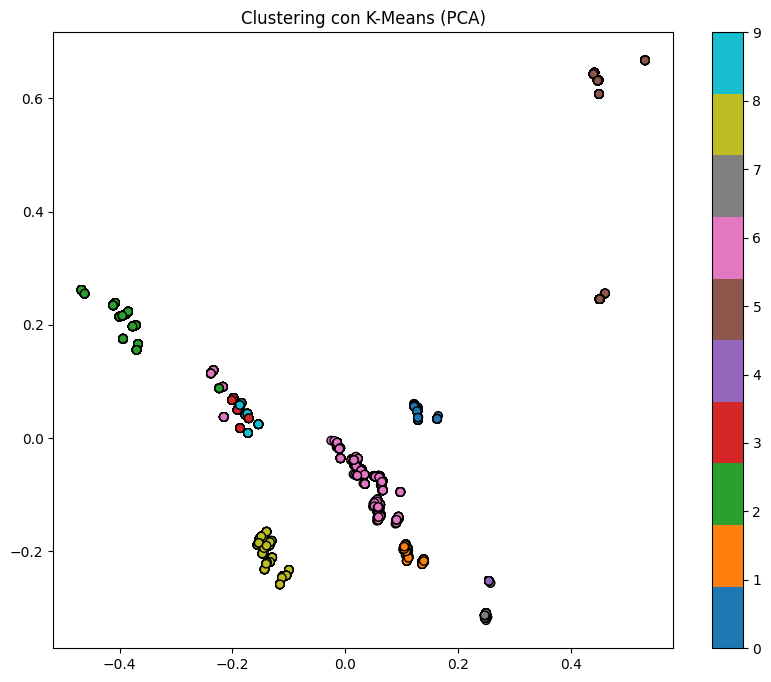

Cluster 0: overflow, detected, port, 168, 192, 151, 51, 251, 201, 101
Cluster 1: attempts, exceeded, authentication, preauth, ssh2, port, 168, 192, test, admin
Cluster 2: error, 168, 192, header, udp, packet, 151, 251, 101, 201
Cluster 3: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 4: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 5: cookies, flooding, sending, detected, syn, port, 168, 192, 101, 251
Cluster 6: 168, 192, port, ssh2, 51, 101, 251, 201, failed, completed
Cluster 7: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 8: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 9: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474


In [16]:
plot_and_print_clusters(X_pca, kmeans_labels, 'Clustering con K-Means (PCA)', kmeans_cluster_terms, n_clusters=10)


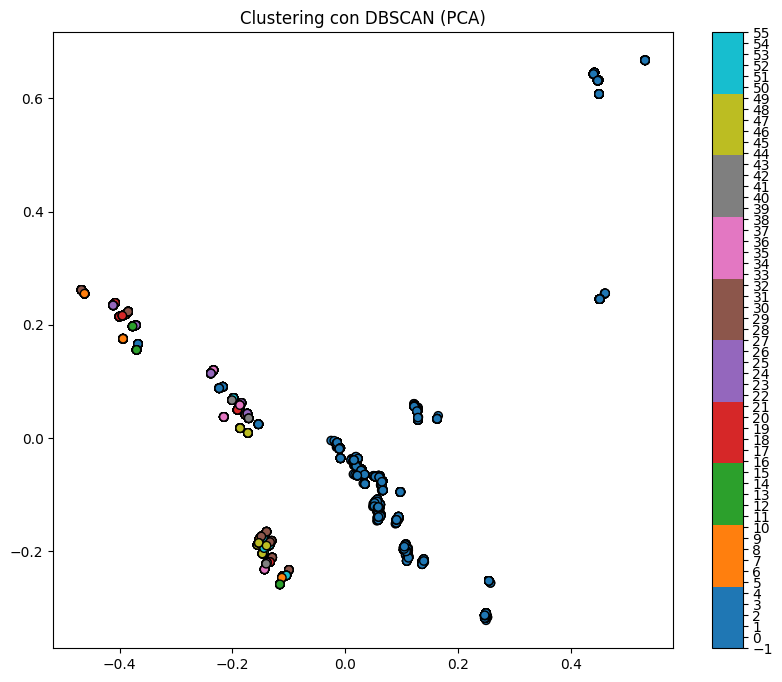

Cluster 0: flooding, sending, cookies, detected, 168, 192, 101, 251, 151, 201
Cluster 1: 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478, 48481
Cluster 2: 201, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 3: unreachable, 192, 168, 4840, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 4: 151, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 5: 51, udp, packet, error, 168, 192, 0x10000, 48392, 4840, 48418
Cluster 6: admin, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474
Cluster 7: admin, logged, 251, 192, 168, 48392, 4840, 48418, 48421, 48439
Cluster 8: 251, header, error, 168, 192, 4840, 48418, 48421, 48439, 48474
Cluster 9: guest, logged, 151, 168, 192, 0x10000, 48418, 48421, 48439, 48474
Cluster 10: header, error, 168, 192, 0x10000, 48418, 48421, 48439, 48474, 48477
Cluster 11: 151, header, error, 168, 192, 0x10000, 48421, 48439, 48474, 48477
Cluster 12: test, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474

In [17]:
plot_and_print_clusters(X_pca, dbscan_labels, 'Clustering con DBSCAN (PCA)', dbscan_cluster_terms)


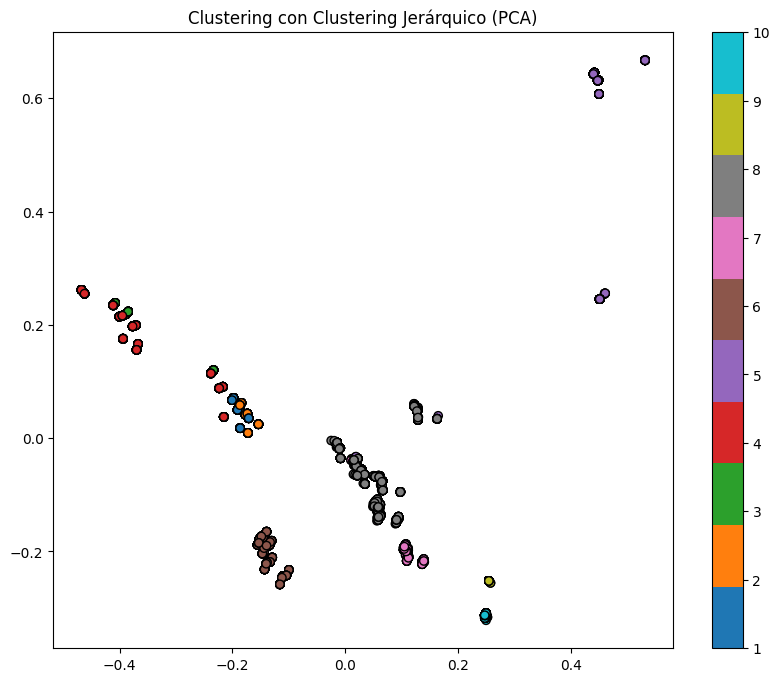

Cluster 1: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 2: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 3: 101, 168, 192, error, header, udp, packet, 0x10000, 48392, 4840
Cluster 4: 168, 192, error, header, udp, 251, 151, 201, 51, packet
Cluster 5: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 6: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 7: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin
Cluster 8: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 9: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 10: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user


In [18]:
plot_and_print_clusters(X_pca, hierarchical_labels, 'Clustering con Clustering Jerárquico (PCA)', hierarchical_cluster_terms)


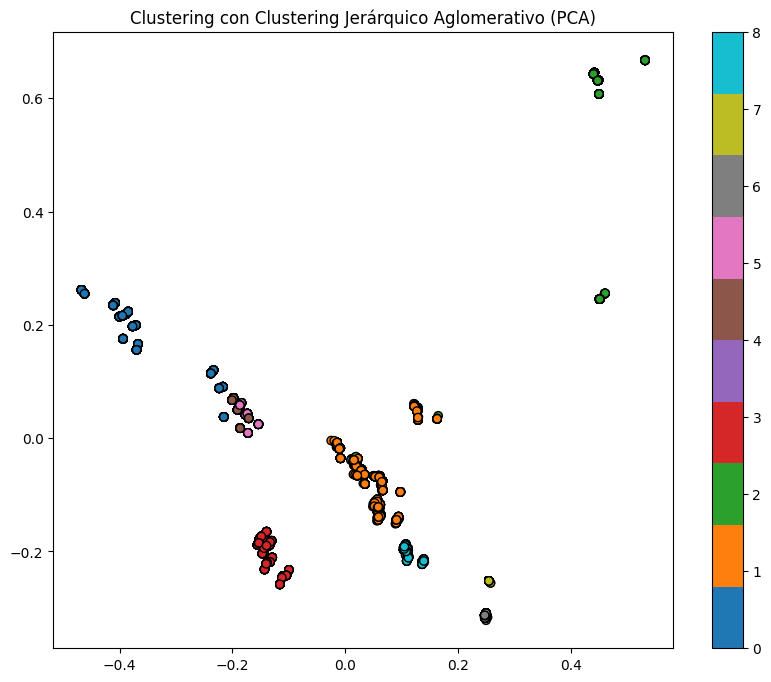

Cluster 0: 168, 192, error, header, udp, packet, 251, 101, 151, 201
Cluster 1: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 2: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 3: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 4: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 5: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 6: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 7: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 8: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin


In [19]:
plot_and_print_clusters(X_pca, agglomerative_labels, 'Clustering con Clustering Jerárquico Aglomerativo (PCA)', agglomerative_cluster_terms)

Como se obtienen demasiados clusters con DBSCAN (por cómo es su funcionamiento interno), se han creado estas funciones que agrupan clusters similares:

- La función **group_similar_clusters** agrupa los clusters que tienen palabras clave similares usando el *índice/coeficiente de Jaccard* para determinar la siilitud entre conjuntos de palabras clave. Ésta itera sobre cada cluster comparando sus términos con los de los otros clusters y si el índice de Jaccard entre dos clusters supera un umbral predefinifo, agrupa los clusters. De este modo la función da un conjunto de grupos que están representados cada uno por un cluster líder y un solo conjunto de términos que incluyen todos los de la agrupación.

- La función *plot_grouped_clusters* sirve para ver los clusters simplemente.

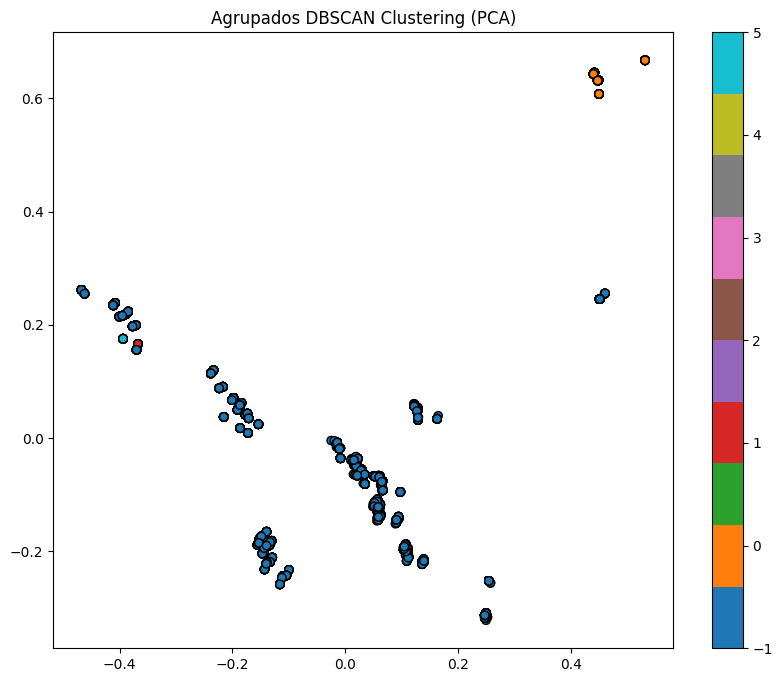

Grouped Cluster 0: 201, invalid_user, flooding, 192, 151, 51, detected, 48672, 101, 251, sending, 168, cookies, logged
Grouped Cluster 1: 48481, header, 48478, 101, 48392, test, packet, 168, 51, root, udp, error, 48418, 48477, icmp, unreachable, guest, 201, 48439, 0x10000, admin, 48474, 4840, 192, 151, 251, 48421, logged
Grouped Cluster 5: 192, udp, 0x10000, 4840, error, 48418, 48392, packet, 168, 51
Número total de clusters agrupados: 3


In [20]:
# NOTA: Modificar el umbral para que salgan más o menos clusters
def group_similar_clusters(cluster_terms, threshold=0.3):
    used = set()
    groups = []
    group_index = {}

    # Ordenar clusters por cantidad de términos para intentar agrupar primero los más grandes
    for label, terms in sorted(cluster_terms.items(), key=lambda x: -len(set(x[1]))):
        if label in used:
            continue

        # Verificar si el cluster actual es similar a alguno ya existente
        found = False
        for group in groups:
            intersection = len(set(terms) & set(cluster_terms[group[0]]))
            union = len(set(terms) | set(cluster_terms[group[0]]))
            jaccard_index = intersection / union
            if jaccard_index >= threshold:
                group.append(label)
                used.add(label)
                found = True
                break

        # Si no es similar a ningún grupo existente, crear un nuevo grupo
        if not found:
            groups.append([label])
            used.add(label)
            group_index[label] = terms

    # Consolidar términos en grupos
    consolidated_groups = {}
    for group in groups:
        all_terms = []
        for label in group:
            all_terms.extend(cluster_terms[label])
        unique_terms = list(set(all_terms))
        key_label = group[0]  # Usar el primer label como representante
        consolidated_groups[key_label] = unique_terms

    return consolidated_groups

# Aplicar la función de agrupación a los términos de cluster de DBSCAN
dbscan_grouped_terms = group_similar_clusters(dbscan_cluster_terms)

# Función para visualizar los clusters agrupados
def plot_grouped_clusters(X_pca, labels, grouped_terms, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[label if label in grouped_terms else -1 for label in labels], cmap='tab10', marker='o', edgecolor='black')
    plt.title(title)
    plt.colorbar(scatter)
    plt.show()

    for label, terms in grouped_terms.items():
        print(f"Grouped Cluster {label}: {', '.join(terms)}")

# Grafica los clusters agrupados de DBSCAN
plot_grouped_clusters(X_pca, dbscan_labels, dbscan_grouped_terms, 'Agrupados DBSCAN Clustering (PCA)')

# Calcular e imprimir el número de clusters agrupados
num_grouped_clusters = len(dbscan_grouped_terms)
print("Número total de clusters agrupados:", num_grouped_clusters)


## Reducción de la dimensionalidad con t-SNE

In [21]:
# Aplicar t-SNE para reducir la dimensionalidad a 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())


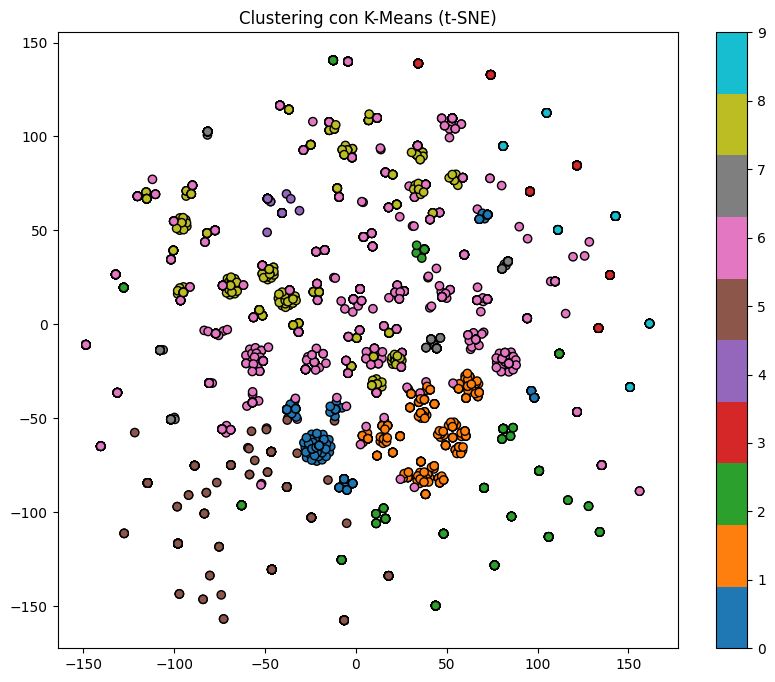

Cluster 0: overflow, detected, port, 168, 192, 151, 51, 251, 201, 101
Cluster 1: attempts, exceeded, authentication, preauth, ssh2, port, 168, 192, test, admin
Cluster 2: error, 168, 192, header, udp, packet, 151, 251, 101, 201
Cluster 3: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 4: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 5: cookies, flooding, sending, detected, syn, port, 168, 192, 101, 251
Cluster 6: 168, 192, port, ssh2, 51, 101, 251, 201, failed, completed
Cluster 7: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 8: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 9: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474


In [22]:
plot_and_print_clusters(X_tsne, kmeans_labels, 'Clustering con K-Means (t-SNE)', kmeans_cluster_terms, n_clusters=10)


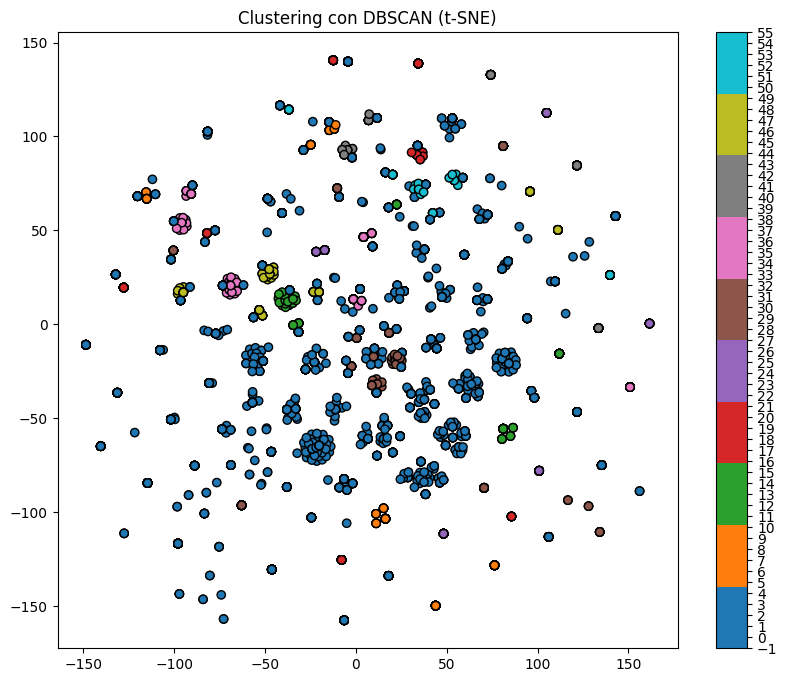

Cluster 0: flooding, sending, cookies, detected, 168, 192, 101, 251, 151, 201
Cluster 1: 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478, 48481
Cluster 2: 201, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 3: unreachable, 192, 168, 4840, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 4: 151, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 5: 51, udp, packet, error, 168, 192, 0x10000, 48392, 4840, 48418
Cluster 6: admin, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474
Cluster 7: admin, logged, 251, 192, 168, 48392, 4840, 48418, 48421, 48439
Cluster 8: 251, header, error, 168, 192, 4840, 48418, 48421, 48439, 48474
Cluster 9: guest, logged, 151, 168, 192, 0x10000, 48418, 48421, 48439, 48474
Cluster 10: header, error, 168, 192, 0x10000, 48418, 48421, 48439, 48474, 48477
Cluster 11: 151, header, error, 168, 192, 0x10000, 48421, 48439, 48474, 48477
Cluster 12: test, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474

In [23]:
plot_and_print_clusters(X_tsne, dbscan_labels, 'Clustering con DBSCAN (t-SNE)', dbscan_cluster_terms)


DBSCAN agrupando clusters

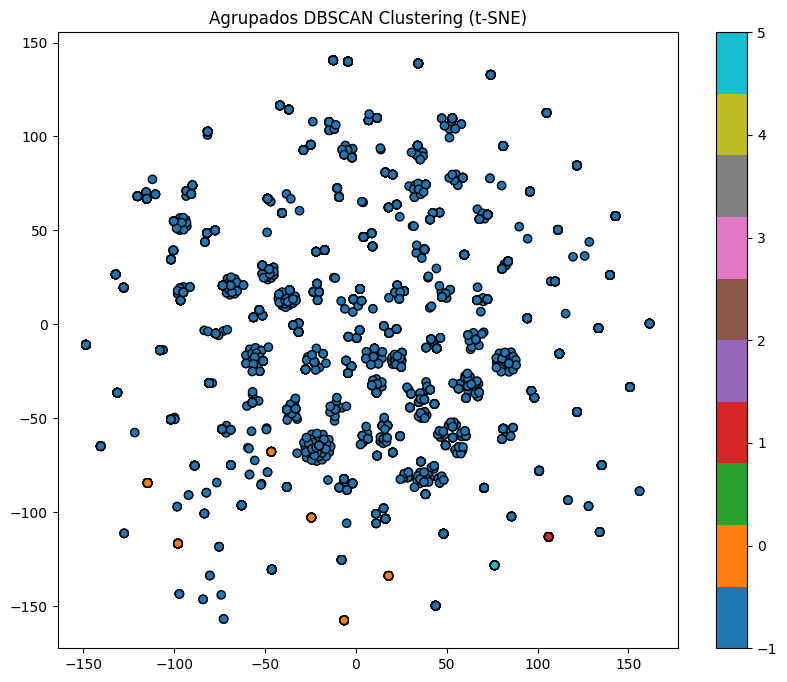

Grouped Cluster 0: 201, invalid_user, flooding, 192, 151, 51, detected, 48672, 101, 251, sending, 168, cookies, logged
Grouped Cluster 1: 48481, header, 48478, 101, 48392, test, packet, 168, 51, root, udp, error, 48418, 48477, icmp, unreachable, guest, 201, 48439, 0x10000, admin, 48474, 4840, 192, 151, 251, 48421, logged
Grouped Cluster 5: 192, udp, 0x10000, 4840, error, 48418, 48392, packet, 168, 51
Número total de clusters agrupados: 3


In [24]:
plot_grouped_clusters(X_tsne, dbscan_labels, dbscan_grouped_terms, 'Agrupados DBSCAN Clustering (t-SNE)')

# Calcular e imprimir el número de clusters agrupados
num_grouped_clusters = len(dbscan_grouped_terms)
print("Número total de clusters agrupados:", num_grouped_clusters)

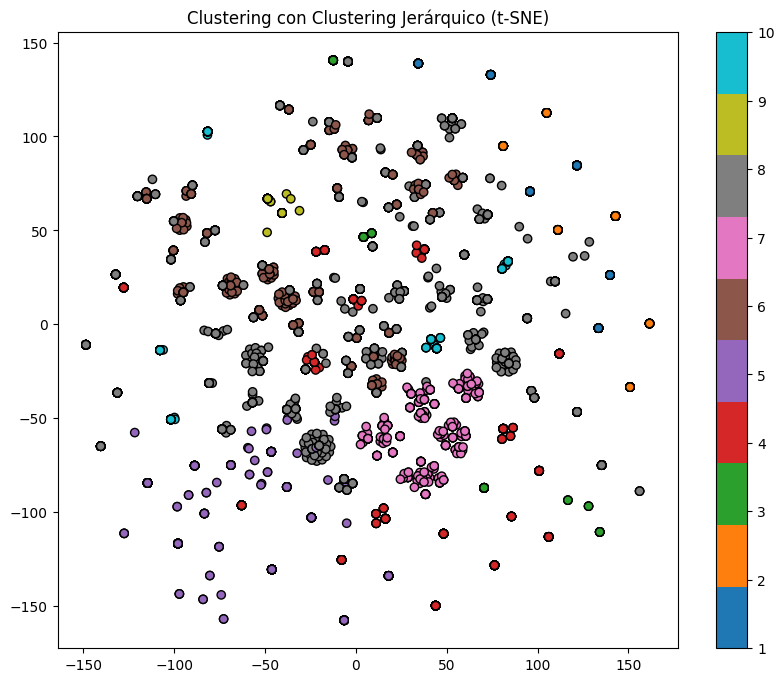

Cluster 1: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 2: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 3: 101, 168, 192, error, header, udp, packet, 0x10000, 48392, 4840
Cluster 4: 168, 192, error, header, udp, 251, 151, 201, 51, packet
Cluster 5: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 6: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 7: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin
Cluster 8: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 9: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 10: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user


In [25]:
plot_and_print_clusters(X_tsne, hierarchical_labels, 'Clustering con Clustering Jerárquico (t-SNE)', hierarchical_cluster_terms)


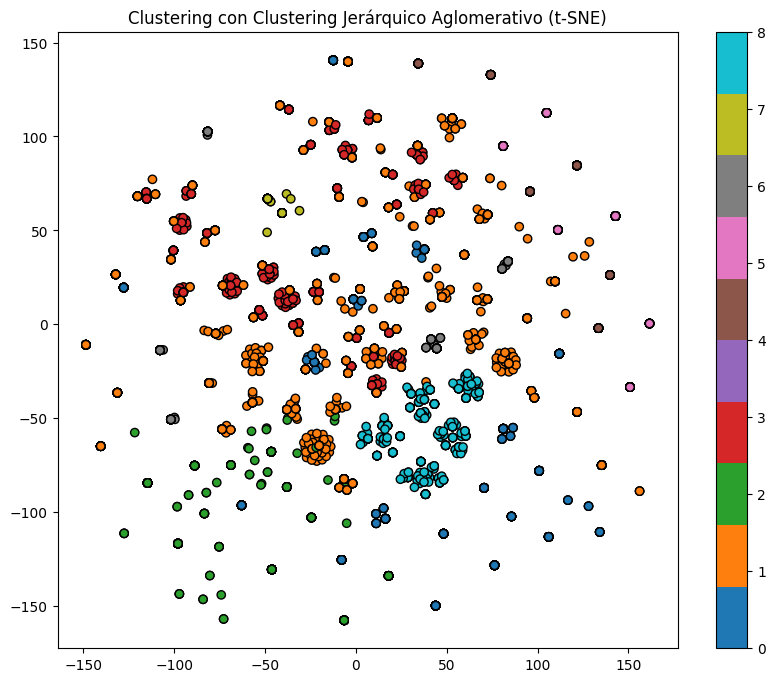

Cluster 0: 168, 192, error, header, udp, packet, 251, 101, 151, 201
Cluster 1: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 2: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 3: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 4: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 5: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 6: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 7: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 8: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin


In [26]:
plot_and_print_clusters(X_tsne, agglomerative_labels, 'Clustering con Clustering Jerárquico Aglomerativo (t-SNE)', agglomerative_cluster_terms)

## Reducción de la dimensionalidad con UMAP

In [27]:
# Aplicar UMAP para reducir la dimensionalidad a 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X.toarray())


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


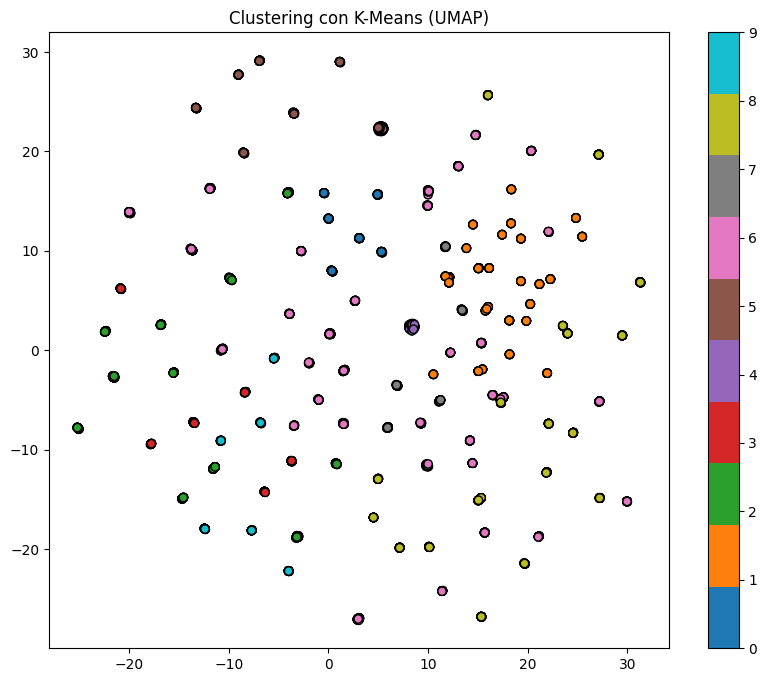

Cluster 0: overflow, detected, port, 168, 192, 151, 51, 251, 201, 101
Cluster 1: attempts, exceeded, authentication, preauth, ssh2, port, 168, 192, test, admin
Cluster 2: error, 168, 192, header, udp, packet, 151, 251, 101, 201
Cluster 3: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 4: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 5: cookies, flooding, sending, detected, syn, port, 168, 192, 101, 251
Cluster 6: 168, 192, port, ssh2, 51, 101, 251, 201, failed, completed
Cluster 7: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 8: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 9: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474


In [28]:
plot_and_print_clusters(X_umap, kmeans_labels, 'Clustering con K-Means (UMAP)', kmeans_cluster_terms, n_clusters=10)


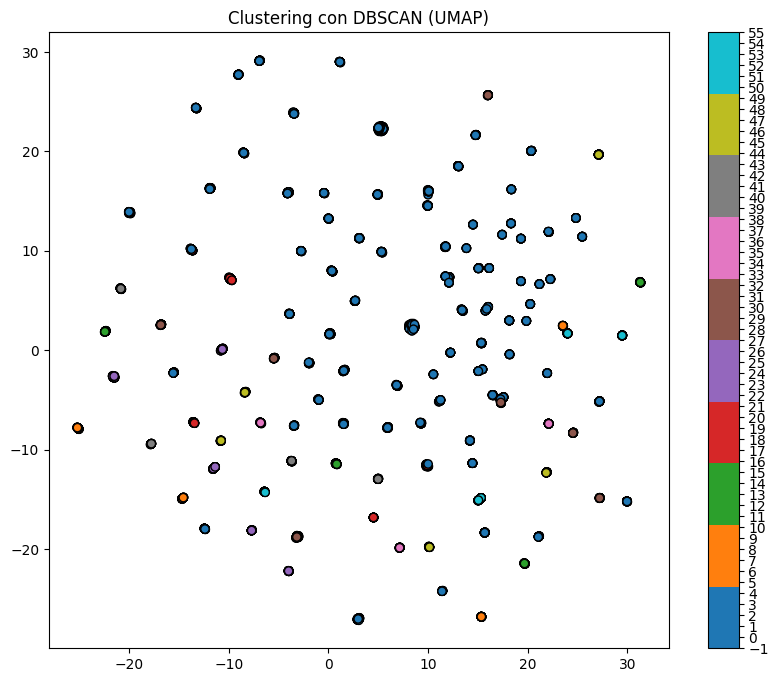

Cluster 0: flooding, sending, cookies, detected, 168, 192, 101, 251, 151, 201
Cluster 1: 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478, 48481
Cluster 2: 201, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 3: unreachable, 192, 168, 4840, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 4: 151, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 5: 51, udp, packet, error, 168, 192, 0x10000, 48392, 4840, 48418
Cluster 6: admin, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474
Cluster 7: admin, logged, 251, 192, 168, 48392, 4840, 48418, 48421, 48439
Cluster 8: 251, header, error, 168, 192, 4840, 48418, 48421, 48439, 48474
Cluster 9: guest, logged, 151, 168, 192, 0x10000, 48418, 48421, 48439, 48474
Cluster 10: header, error, 168, 192, 0x10000, 48418, 48421, 48439, 48474, 48477
Cluster 11: 151, header, error, 168, 192, 0x10000, 48421, 48439, 48474, 48477
Cluster 12: test, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474

In [29]:
plot_and_print_clusters(X_umap, dbscan_labels, 'Clustering con DBSCAN (UMAP)', dbscan_cluster_terms)


DBSCAN agrupando clusters

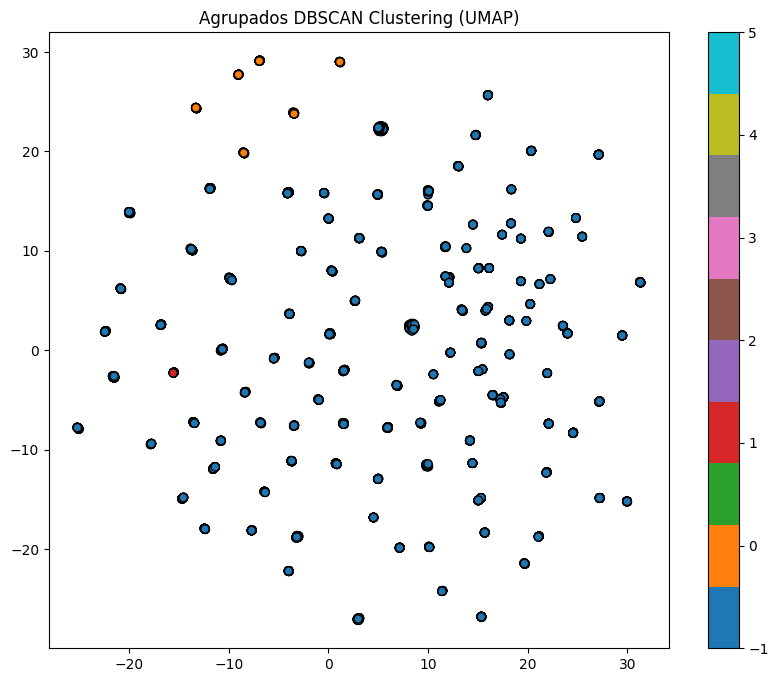

Grouped Cluster 0: 201, invalid_user, flooding, 192, 151, 51, detected, 48672, 101, 251, sending, 168, cookies, logged
Grouped Cluster 1: 48481, header, 48478, 101, 48392, test, packet, 168, 51, root, udp, error, 48418, 48477, icmp, unreachable, guest, 201, 48439, 0x10000, admin, 48474, 4840, 192, 151, 251, 48421, logged
Grouped Cluster 5: 192, udp, 0x10000, 4840, error, 48418, 48392, packet, 168, 51
Número total de clusters agrupados: 3


In [30]:
plot_grouped_clusters(X_umap, dbscan_labels, dbscan_grouped_terms, 'Agrupados DBSCAN Clustering (UMAP)')

# Calcular e imprimir el número de clusters agrupados
num_grouped_clusters = len(dbscan_grouped_terms)
print("Número total de clusters agrupados:", num_grouped_clusters)

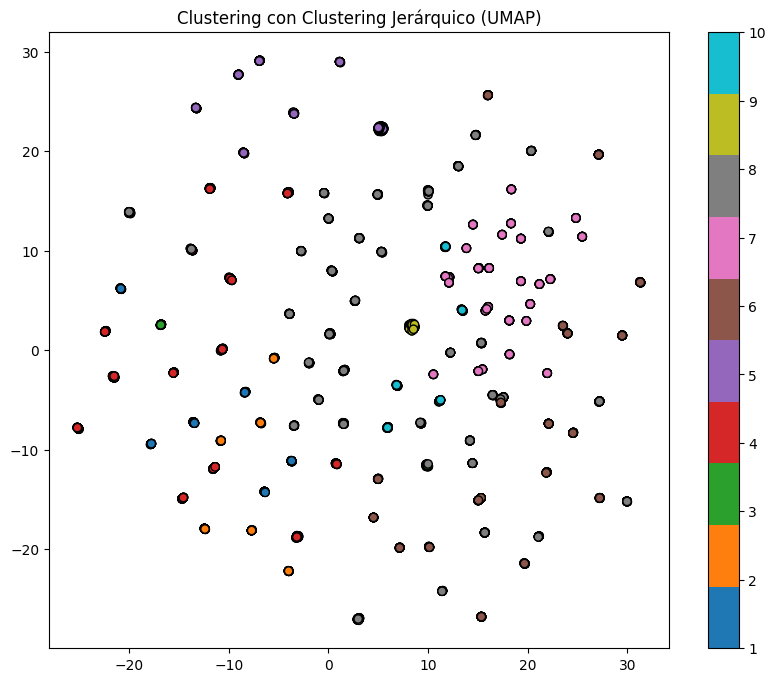

Cluster 1: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 2: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 3: 101, 168, 192, error, header, udp, packet, 0x10000, 48392, 4840
Cluster 4: 168, 192, error, header, udp, 251, 151, 201, 51, packet
Cluster 5: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 6: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 7: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin
Cluster 8: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 9: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 10: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user


In [31]:
plot_and_print_clusters(X_umap, hierarchical_labels, 'Clustering con Clustering Jerárquico (UMAP)', hierarchical_cluster_terms)


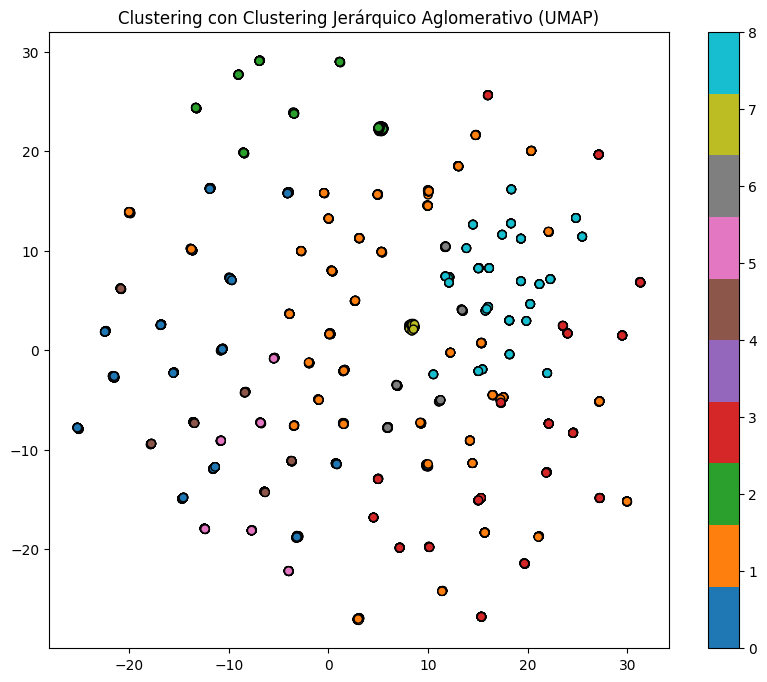

Cluster 0: 168, 192, error, header, udp, packet, 251, 101, 151, 201
Cluster 1: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 2: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 3: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 4: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 5: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 6: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 7: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 8: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin


In [32]:
plot_and_print_clusters(X_umap, agglomerative_labels, 'Clustering con Clustering Jerárquico Aglomerativo (UMAP)', agglomerative_cluster_terms)


## Métricas

Silhouette score: Mide la cohesión y separación de los clusters. Valores altos indican que los clusters están bien definidos y separados.

Ínidce Davies-Bouldin: Evalúa lo compactos que sean los clusters y lo separados que estén entre sí, valores más bajos indican mejores clusters.

Índices Calinski-Harabasz: Cuantifica la varianza entre los clusters comparada con la varianza dentro de los clusters, cuanto más alto el valor mejor.

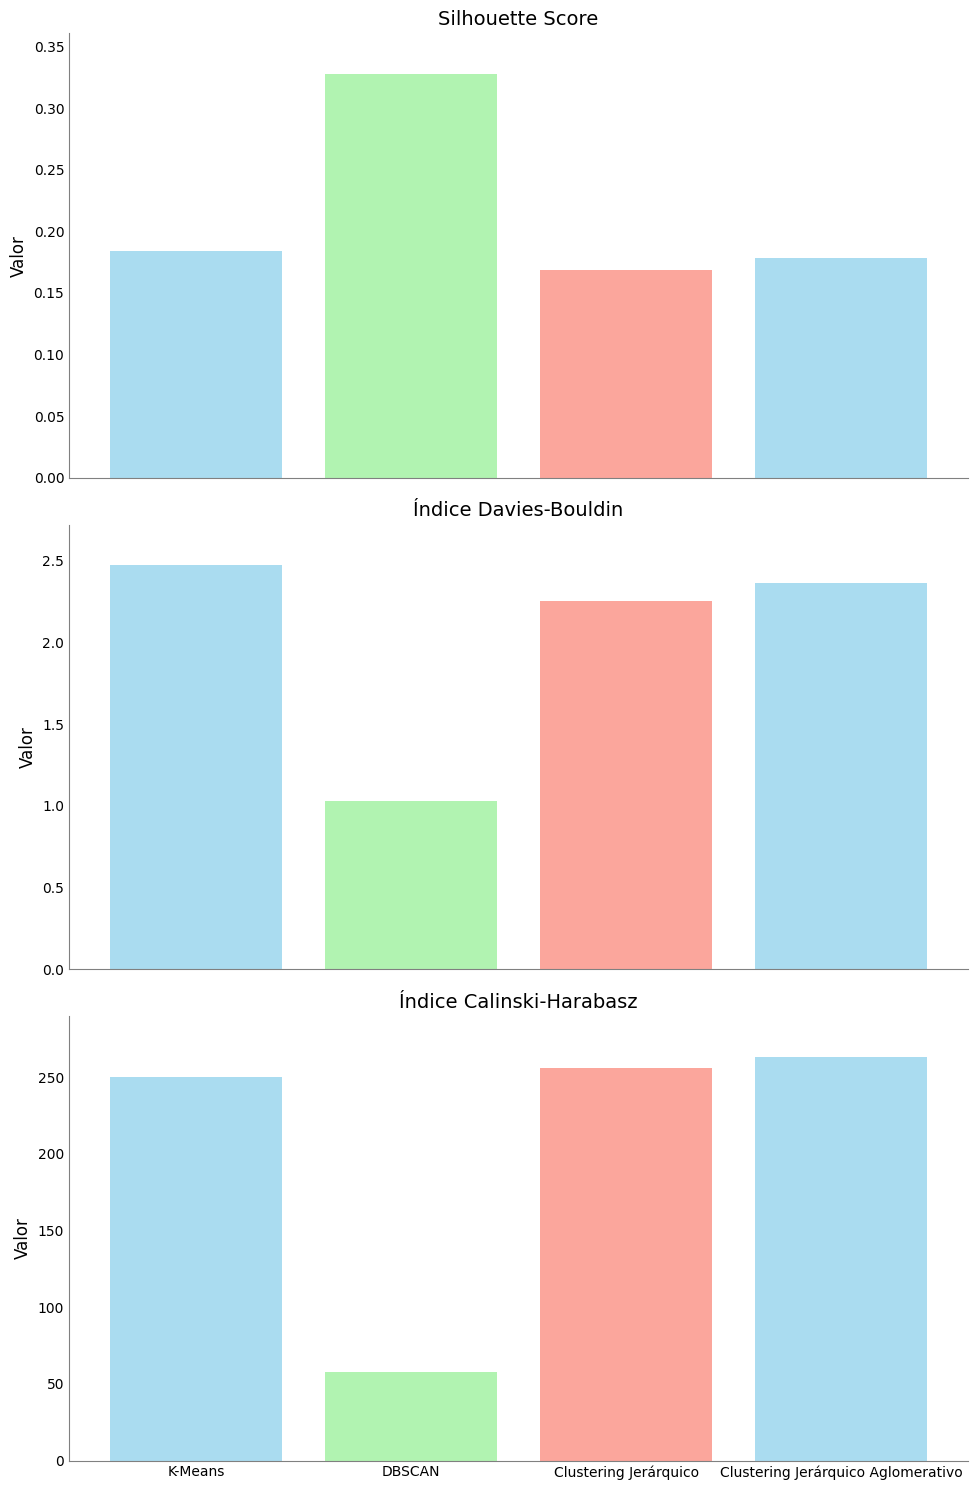

In [33]:
# Inicializar el diccionario con los nombres de las métricas como claves
metrics = {
    'Silhouette Score': [],
    'Índice Davies-Bouldin': [],
    'Índice Calinski-Harabasz': []
}

# Lista de etiquetas de clustering
labels_list = [kmeans_labels, dbscan_labels, hierarchical_labels, agglomerative_labels]

# Función para calcular las métricas de manera condicional para DBSCAN
def calculate_metrics(X, labels):
    if len(set(labels)) > 1:  # Válido para métricas
        return [
            silhouette_score(X, labels),
            davies_bouldin_score(X.toarray(), labels),
            calinski_harabasz_score(X.toarray(), labels)
        ]
    else:  # No aplicable si DBSCAN tiene menos de 2 clusters
        return ["No aplicable"] * 3

# Calcular y almacenar cada métrica para cada método de clustering
for labels in labels_list:
    results = calculate_metrics(X, labels)
    for metric_name, result in zip(metrics.keys(), results):
        metrics[metric_name].append(result)

# Nombres de las columnas para el DataFrame
column_names = ['K-Means', 'DBSCAN', 'Clustering Jerárquico', 'Clustering Jerárquico Aglomerativo']

# Crear DataFrame con las métricas como filas y los métodos como columnas
metrics_df = pd.DataFrame(metrics, index=column_names)

# Aplicar estilos al DataFrame
styled_df = metrics_df.style.background_gradient(cmap='coolwarm') \
                            .set_properties(**{'text-align': 'center', 'font-size': '12pt', 'color': 'black'}) \
                            .set_table_styles([{
                                'selector': 'th',
                                'props': [('font-size', '14pt'), ('background-color', 'lightgrey')]
                            }, {
                                'selector': 'td',
                                'props': [('background-color', 'white')]
                            }])

# Crear gráficos de las métricas
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
colors = ['skyblue', 'lightgreen', 'salmon']
for ax, (metric, values) in zip(axes, metrics.items()):
    values = [0 if v == "No aplicable" else v for v in values]
    bars = ax.bar(column_names, values, color=colors, alpha=0.7)
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel('Valor', fontsize=12)
    ax.set_ylim(0, max(values) + (0.1 * max(values)))  # Añadir más espacio arriba
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(False)  # Remove grid lines

plt.tight_layout()
plt.show()


In [34]:
# Mostrar la tabla
styled_df

,Silhouette Score,Índice Davies-Bouldin,Índice Calinski-Harabasz
K-Means,0.183675,2.471757,249.890189
DBSCAN,0.327810,1.028901,58.079644
Clustering Jerárquico,0.168854,2.254009,255.864348
Clustering Jerárquico Aglomerativo,0.177956,2.359428,263.570459


# Extracción de características con CountVectorizer

CountVectorizer es una clase de scikit-learn que transforma una colección de textos en una matriz numérica de recuentos de palabras o tokens.

In [35]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


Usaremos CountVectorizer para convertir los mensajes de texto a un formato numérico que los algoritmos de clustering puedan utilizar.

In [36]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['Message']) # X es la matriz


## Reducción de la dimensionalidad con PCA

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())


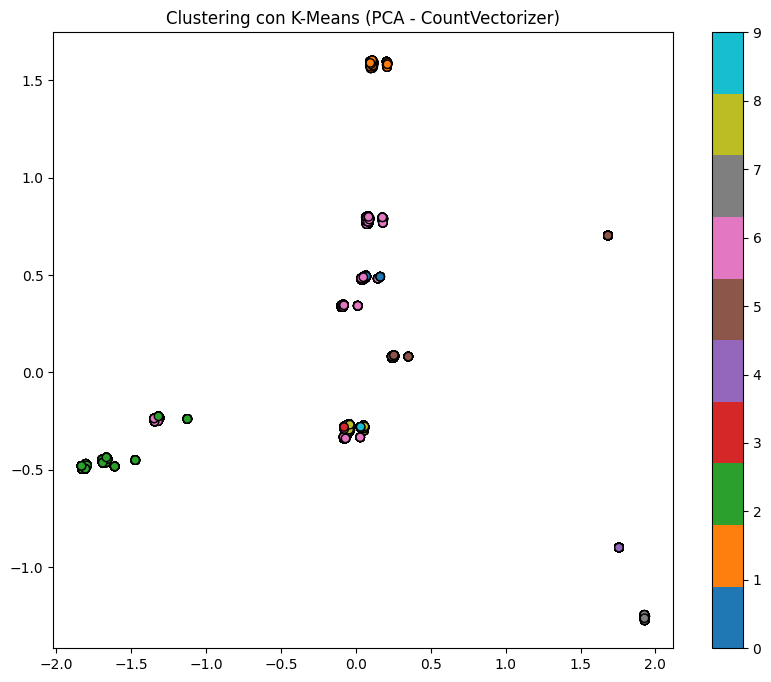

Cluster 0: overflow, detected, port, 168, 192, 151, 51, 251, 201, 101
Cluster 1: attempts, exceeded, authentication, preauth, ssh2, port, 168, 192, test, admin
Cluster 2: error, 168, 192, header, udp, packet, 151, 251, 101, 201
Cluster 3: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 4: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 5: cookies, flooding, sending, detected, syn, port, 168, 192, 101, 251
Cluster 6: 168, 192, port, ssh2, 51, 101, 251, 201, failed, completed
Cluster 7: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 8: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 9: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474


In [38]:
plot_and_print_clusters(X_pca, kmeans_labels, 'Clustering con K-Means (PCA - CountVectorizer)', kmeans_cluster_terms, n_clusters=10)


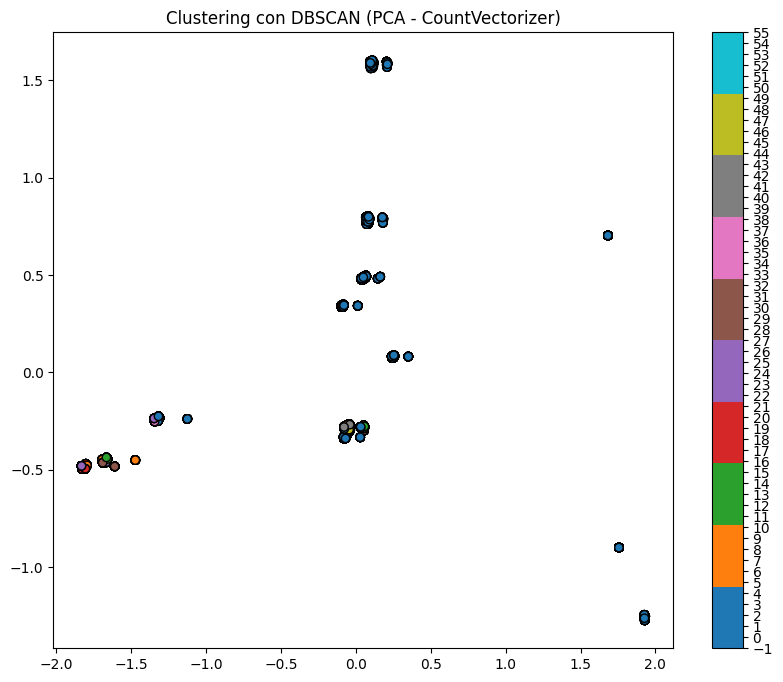

Cluster 0: flooding, sending, cookies, detected, 168, 192, 101, 251, 151, 201
Cluster 1: 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478, 48481
Cluster 2: 201, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 3: unreachable, 192, 168, 4840, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 4: 151, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 5: 51, udp, packet, error, 168, 192, 0x10000, 48392, 4840, 48418
Cluster 6: admin, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474
Cluster 7: admin, logged, 251, 192, 168, 48392, 4840, 48418, 48421, 48439
Cluster 8: 251, header, error, 168, 192, 4840, 48418, 48421, 48439, 48474
Cluster 9: guest, logged, 151, 168, 192, 0x10000, 48418, 48421, 48439, 48474
Cluster 10: header, error, 168, 192, 0x10000, 48418, 48421, 48439, 48474, 48477
Cluster 11: 151, header, error, 168, 192, 0x10000, 48421, 48439, 48474, 48477
Cluster 12: test, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474

In [39]:
plot_and_print_clusters(X_pca, dbscan_labels, 'Clustering con DBSCAN (PCA - CountVectorizer)', dbscan_cluster_terms)


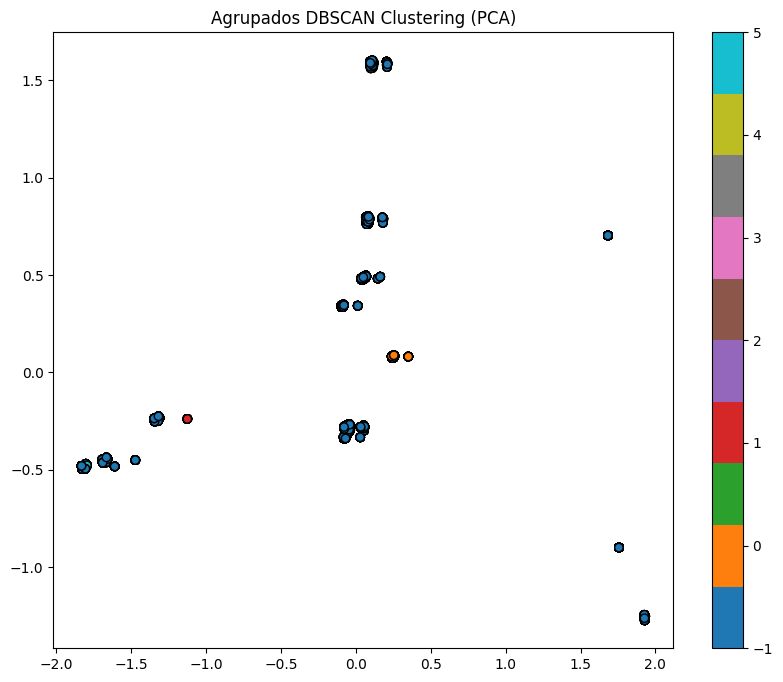

Grouped Cluster 0: 201, invalid_user, flooding, 192, 151, 51, detected, 48672, 101, 251, sending, 168, cookies, logged
Grouped Cluster 1: 48481, header, 48478, 101, 48392, test, packet, 168, 51, root, udp, error, 48418, 48477, icmp, unreachable, guest, 201, 48439, 0x10000, admin, 48474, 4840, 192, 151, 251, 48421, logged
Grouped Cluster 5: 192, udp, 0x10000, 4840, error, 48418, 48392, packet, 168, 51
Número total de clusters agrupados: 3


In [40]:
plot_grouped_clusters(X_pca, dbscan_labels, dbscan_grouped_terms, 'Agrupados DBSCAN Clustering (PCA)')

# Calcular e imprimir el número de clusters agrupados
num_grouped_clusters = len(dbscan_grouped_terms)
print("Número total de clusters agrupados:", num_grouped_clusters)

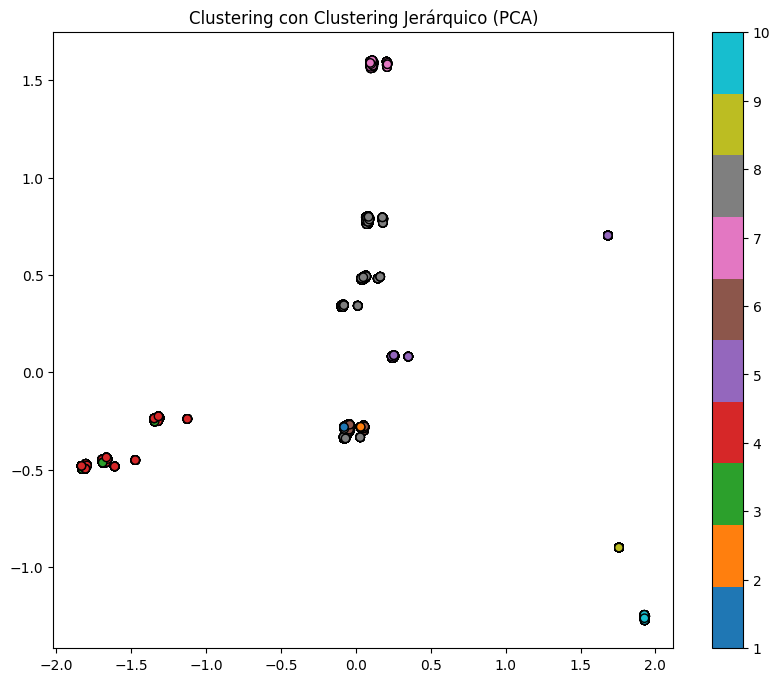

Cluster 1: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 2: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 3: 101, 168, 192, error, header, udp, packet, 0x10000, 48392, 4840
Cluster 4: 168, 192, error, header, udp, 251, 151, 201, 51, packet
Cluster 5: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 6: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 7: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin
Cluster 8: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 9: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 10: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user


In [41]:
plot_and_print_clusters(X_pca, hierarchical_labels, 'Clustering con Clustering Jerárquico (PCA)', hierarchical_cluster_terms)


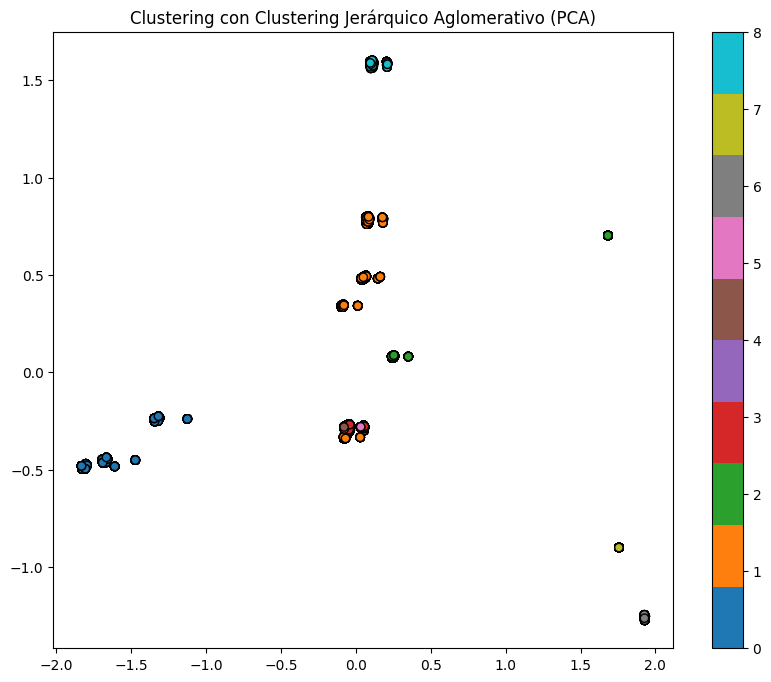

Cluster 0: 168, 192, error, header, udp, packet, 251, 101, 151, 201
Cluster 1: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 2: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 3: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 4: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 5: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 6: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 7: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 8: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin


In [42]:
plot_and_print_clusters(X_pca, agglomerative_labels, 'Clustering con Clustering Jerárquico Aglomerativo (PCA)', agglomerative_cluster_terms)

## Reducción la dimensionalidad con t-SNE

In [43]:
# Aplicar t-SNE para reducir la dimensionalidad
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())


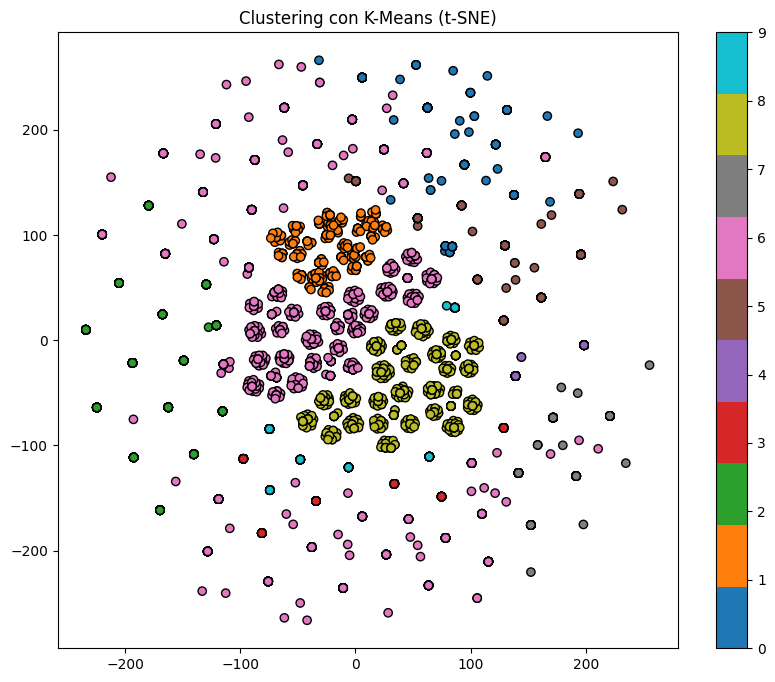

Cluster 0: overflow, detected, port, 168, 192, 151, 51, 251, 201, 101
Cluster 1: attempts, exceeded, authentication, preauth, ssh2, port, 168, 192, test, admin
Cluster 2: error, 168, 192, header, udp, packet, 151, 251, 101, 201
Cluster 3: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 4: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 5: cookies, flooding, sending, detected, syn, port, 168, 192, 101, 251
Cluster 6: 168, 192, port, ssh2, 51, 101, 251, 201, failed, completed
Cluster 7: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 8: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 9: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474


In [44]:
plot_and_print_clusters(X_tsne, kmeans_labels, 'Clustering con K-Means (t-SNE)', kmeans_cluster_terms, n_clusters=10)


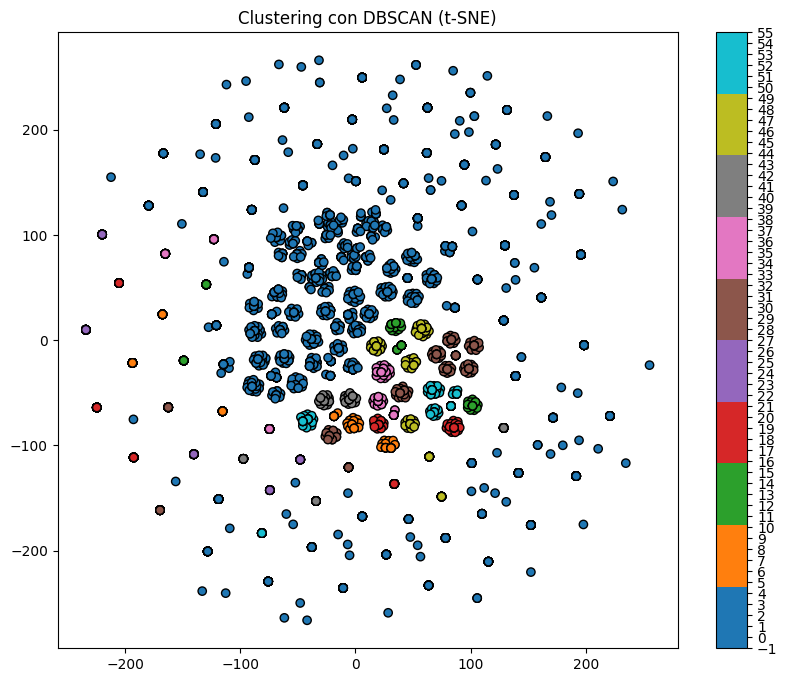

Cluster 0: flooding, sending, cookies, detected, 168, 192, 101, 251, 151, 201
Cluster 1: 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478, 48481
Cluster 2: 201, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 3: unreachable, 192, 168, 4840, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 4: 151, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 5: 51, udp, packet, error, 168, 192, 0x10000, 48392, 4840, 48418
Cluster 6: admin, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474
Cluster 7: admin, logged, 251, 192, 168, 48392, 4840, 48418, 48421, 48439
Cluster 8: 251, header, error, 168, 192, 4840, 48418, 48421, 48439, 48474
Cluster 9: guest, logged, 151, 168, 192, 0x10000, 48418, 48421, 48439, 48474
Cluster 10: header, error, 168, 192, 0x10000, 48418, 48421, 48439, 48474, 48477
Cluster 11: 151, header, error, 168, 192, 0x10000, 48421, 48439, 48474, 48477
Cluster 12: test, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474

In [45]:
plot_and_print_clusters(X_tsne, dbscan_labels, 'Clustering con DBSCAN (t-SNE)', dbscan_cluster_terms)


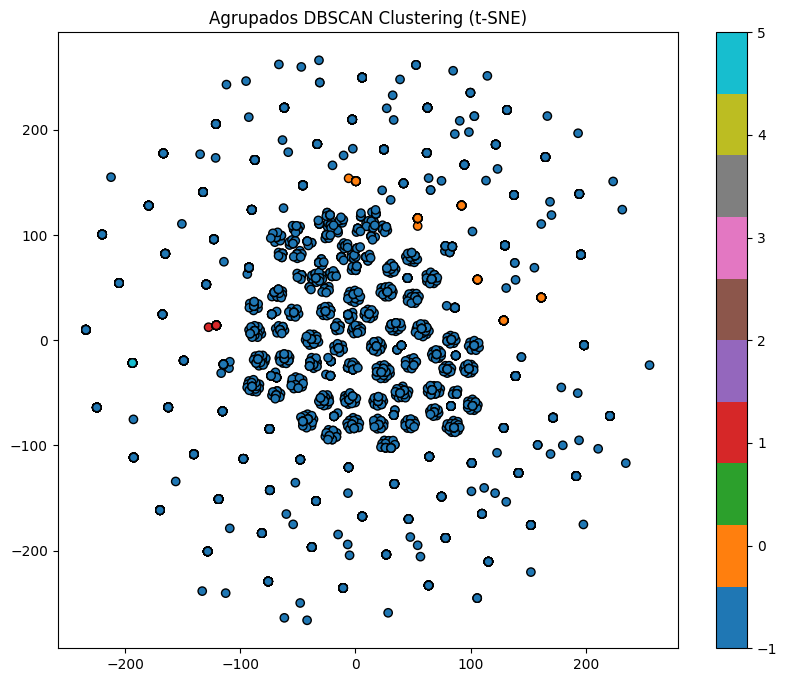

Grouped Cluster 0: 201, invalid_user, flooding, 192, 151, 51, detected, 48672, 101, 251, sending, 168, cookies, logged
Grouped Cluster 1: 48481, header, 48478, 101, 48392, test, packet, 168, 51, root, udp, error, 48418, 48477, icmp, unreachable, guest, 201, 48439, 0x10000, admin, 48474, 4840, 192, 151, 251, 48421, logged
Grouped Cluster 5: 192, udp, 0x10000, 4840, error, 48418, 48392, packet, 168, 51
Número total de clusters agrupados: 3


In [46]:
plot_grouped_clusters(X_tsne, dbscan_labels, dbscan_grouped_terms, 'Agrupados DBSCAN Clustering (t-SNE)')

# Calcular e imprimir el número de clusters agrupados
num_grouped_clusters = len(dbscan_grouped_terms)
print("Número total de clusters agrupados:", num_grouped_clusters)

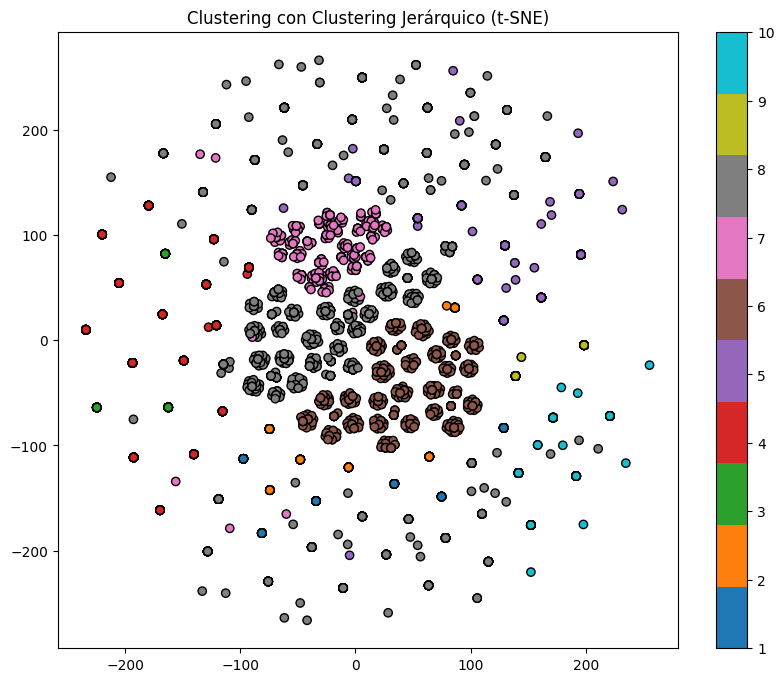

Cluster 1: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 2: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 3: 101, 168, 192, error, header, udp, packet, 0x10000, 48392, 4840
Cluster 4: 168, 192, error, header, udp, 251, 151, 201, 51, packet
Cluster 5: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 6: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 7: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin
Cluster 8: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 9: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 10: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user


In [47]:
plot_and_print_clusters(X_tsne, hierarchical_labels, 'Clustering con Clustering Jerárquico (t-SNE)', hierarchical_cluster_terms)


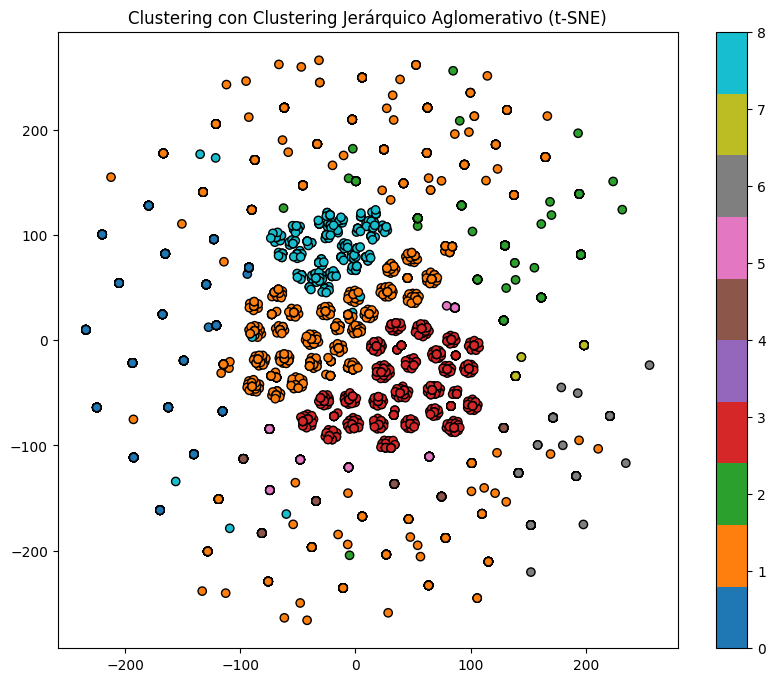

Cluster 0: 168, 192, error, header, udp, packet, 251, 101, 151, 201
Cluster 1: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 2: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 3: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 4: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 5: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 6: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 7: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 8: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin


In [48]:
plot_and_print_clusters(X_tsne, agglomerative_labels, 'Clustering con Clustering Jerárquico Aglomerativo (t-SNE)', agglomerative_cluster_terms)

## Reducción de la dimensionalidad con UMAP

In [49]:
# Aplicar UMAP para reducir la dimensionalidad a 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X.toarray())


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


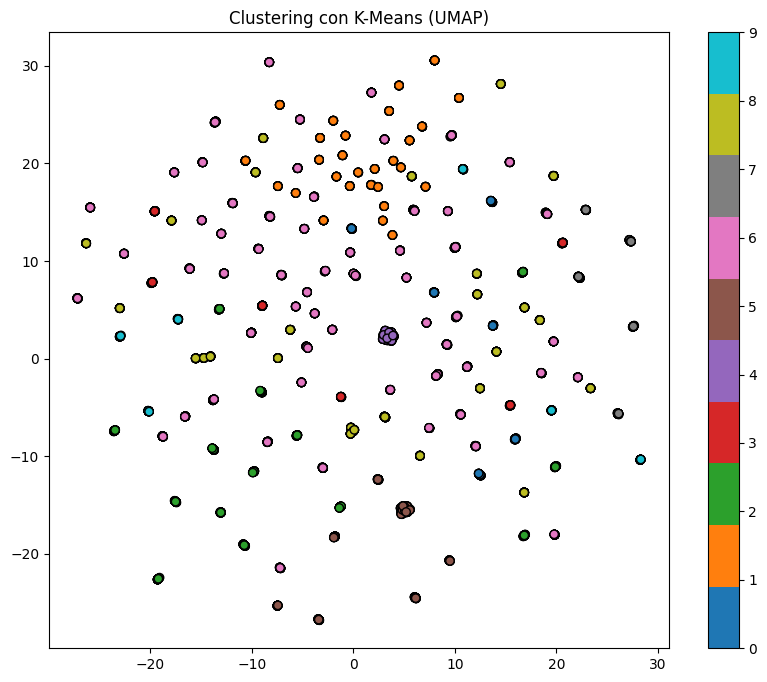

Cluster 0: overflow, detected, port, 168, 192, 151, 51, 251, 201, 101
Cluster 1: attempts, exceeded, authentication, preauth, ssh2, port, 168, 192, test, admin
Cluster 2: error, 168, 192, header, udp, packet, 151, 251, 101, 201
Cluster 3: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 4: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 5: cookies, flooding, sending, detected, syn, port, 168, 192, 101, 251
Cluster 6: 168, 192, port, ssh2, 51, 101, 251, 201, failed, completed
Cluster 7: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 8: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 9: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474


In [50]:
plot_and_print_clusters(X_umap, kmeans_labels, 'Clustering con K-Means (UMAP)', kmeans_cluster_terms, n_clusters=10)


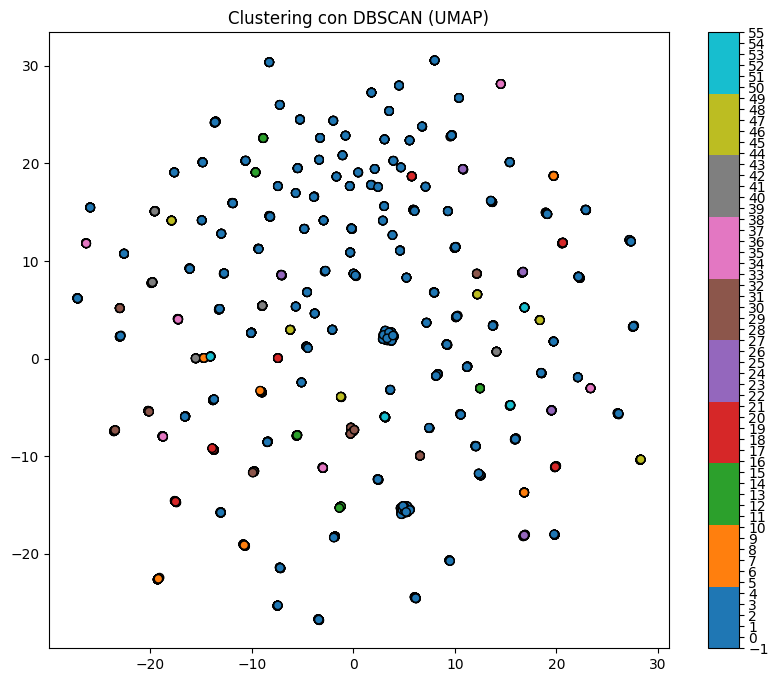

Cluster 0: flooding, sending, cookies, detected, 168, 192, 101, 251, 151, 201
Cluster 1: 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478, 48481
Cluster 2: 201, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 3: unreachable, 192, 168, 4840, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 4: 151, 192, 168, 0x10000, 48418, 48421, 48439, 48474, 48477, 48478
Cluster 5: 51, udp, packet, error, 168, 192, 0x10000, 48392, 4840, 48418
Cluster 6: admin, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474
Cluster 7: admin, logged, 251, 192, 168, 48392, 4840, 48418, 48421, 48439
Cluster 8: 251, header, error, 168, 192, 4840, 48418, 48421, 48439, 48474
Cluster 9: guest, logged, 151, 168, 192, 0x10000, 48418, 48421, 48439, 48474
Cluster 10: header, error, 168, 192, 0x10000, 48418, 48421, 48439, 48474, 48477
Cluster 11: 151, header, error, 168, 192, 0x10000, 48421, 48439, 48474, 48477
Cluster 12: test, logged, 192, 168, 0x10000, 4840, 48418, 48421, 48439, 48474

In [51]:
plot_and_print_clusters(X_umap, dbscan_labels, 'Clustering con DBSCAN (UMAP)', dbscan_cluster_terms)


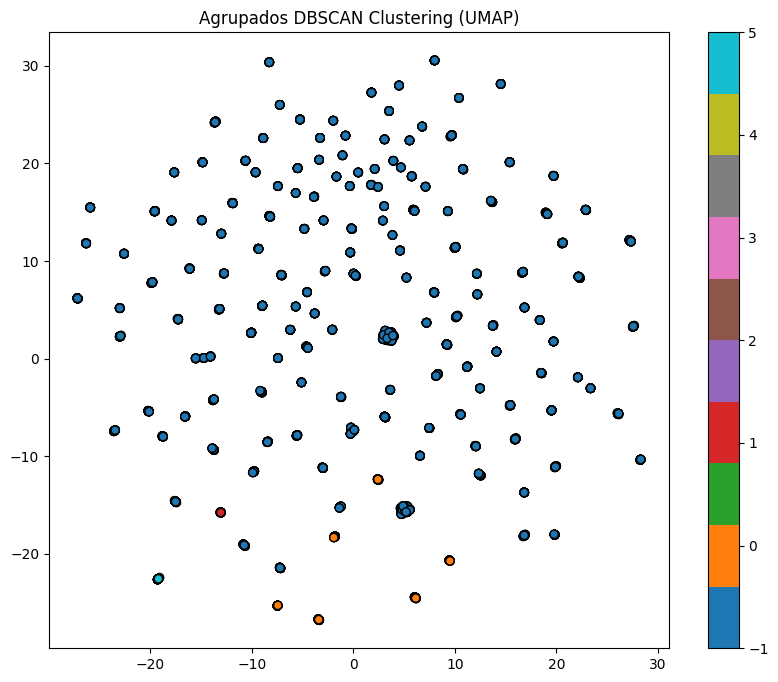

Grouped Cluster 0: 201, invalid_user, flooding, 192, 151, 51, detected, 48672, 101, 251, sending, 168, cookies, logged
Grouped Cluster 1: 48481, header, 48478, 101, 48392, test, packet, 168, 51, root, udp, error, 48418, 48477, icmp, unreachable, guest, 201, 48439, 0x10000, admin, 48474, 4840, 192, 151, 251, 48421, logged
Grouped Cluster 5: 192, udp, 0x10000, 4840, error, 48418, 48392, packet, 168, 51
Número total de clusters agrupados: 3


In [52]:
plot_grouped_clusters(X_umap, dbscan_labels, dbscan_grouped_terms, 'Agrupados DBSCAN Clustering (UMAP)')

# Calcular e imprimir el número de clusters agrupados
num_grouped_clusters = len(dbscan_grouped_terms)
print("Número total de clusters agrupados:", num_grouped_clusters)

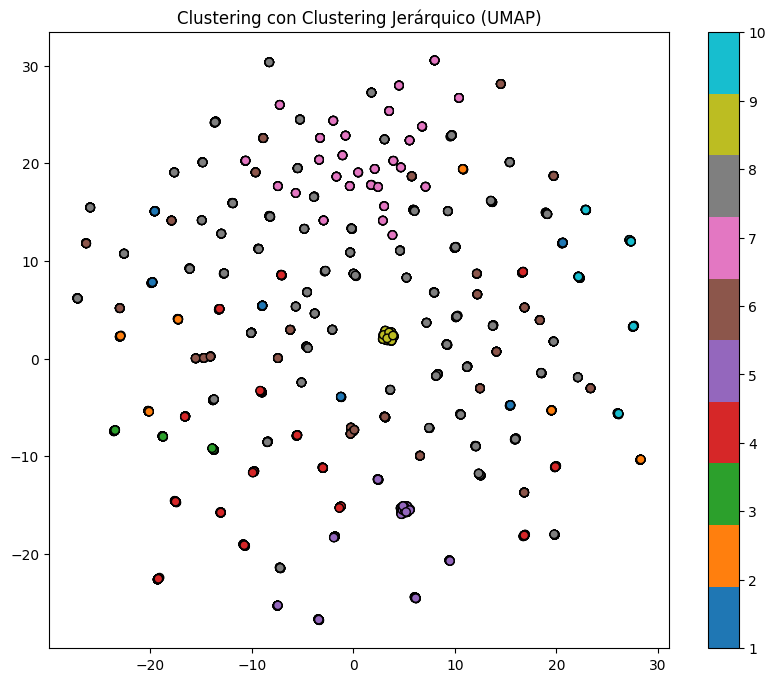

Cluster 1: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 2: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 3: 101, 168, 192, error, header, udp, packet, 0x10000, 48392, 4840
Cluster 4: 168, 192, error, header, udp, 251, 151, 201, 51, packet
Cluster 5: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 6: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 7: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin
Cluster 8: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 9: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 10: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user


In [53]:
plot_and_print_clusters(X_umap, hierarchical_labels, 'Clustering con Clustering Jerárquico (UMAP)', hierarchical_cluster_terms)


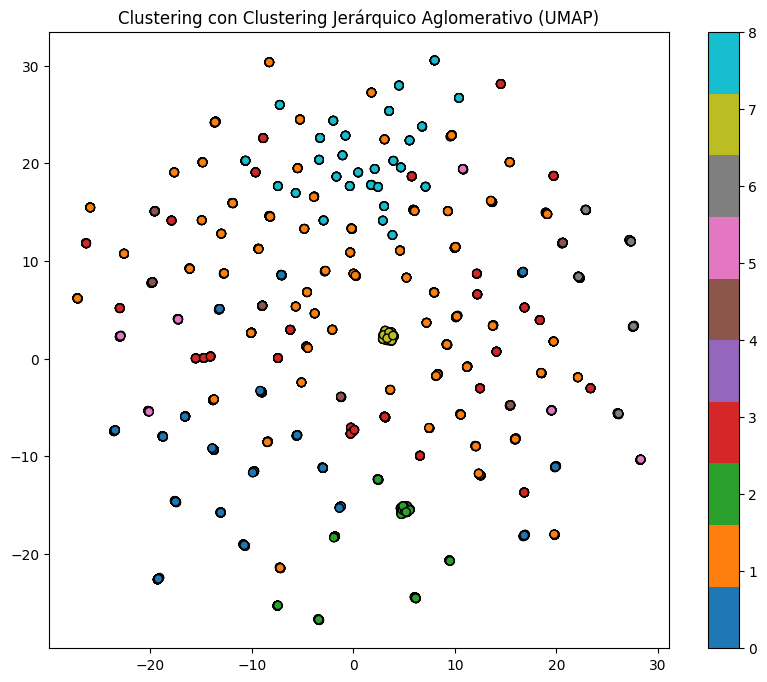

Cluster 0: 168, 192, error, header, udp, packet, 251, 101, 151, 201
Cluster 1: port, 168, 192, ssh2, failed, transfer, completed, user, disconnected, 51
Cluster 2: cookies, flooding, sending, detected, syn, port, 192, 168, 101, 201
Cluster 3: logged, 168, 192, test, admin, guest, root, invalid_user, 51, 101
Cluster 4: icmp, 192, 168, 151, 201, 101, 251, 51, 48439, 48474
Cluster 5: unreachable, 192, 168, 151, 251, 51, 101, 201, 48439, 48474
Cluster 6: kill, memory, child, process, service, score, sacrifice, root, test, invalid_user
Cluster 7: gfp_mask, invoked, killer, oom, oom_score_adj, order, 0x61301, 0x10000, 0x5153, 0x51415
Cluster 8: exceeded, authentication, attempts, preauth, ssh2, port, 192, 168, test, admin


In [54]:
plot_and_print_clusters(X_umap, agglomerative_labels, 'Clustering con Clustering Jerárquico Aglomerativo (UMAP)', agglomerative_cluster_terms)


## Métricas

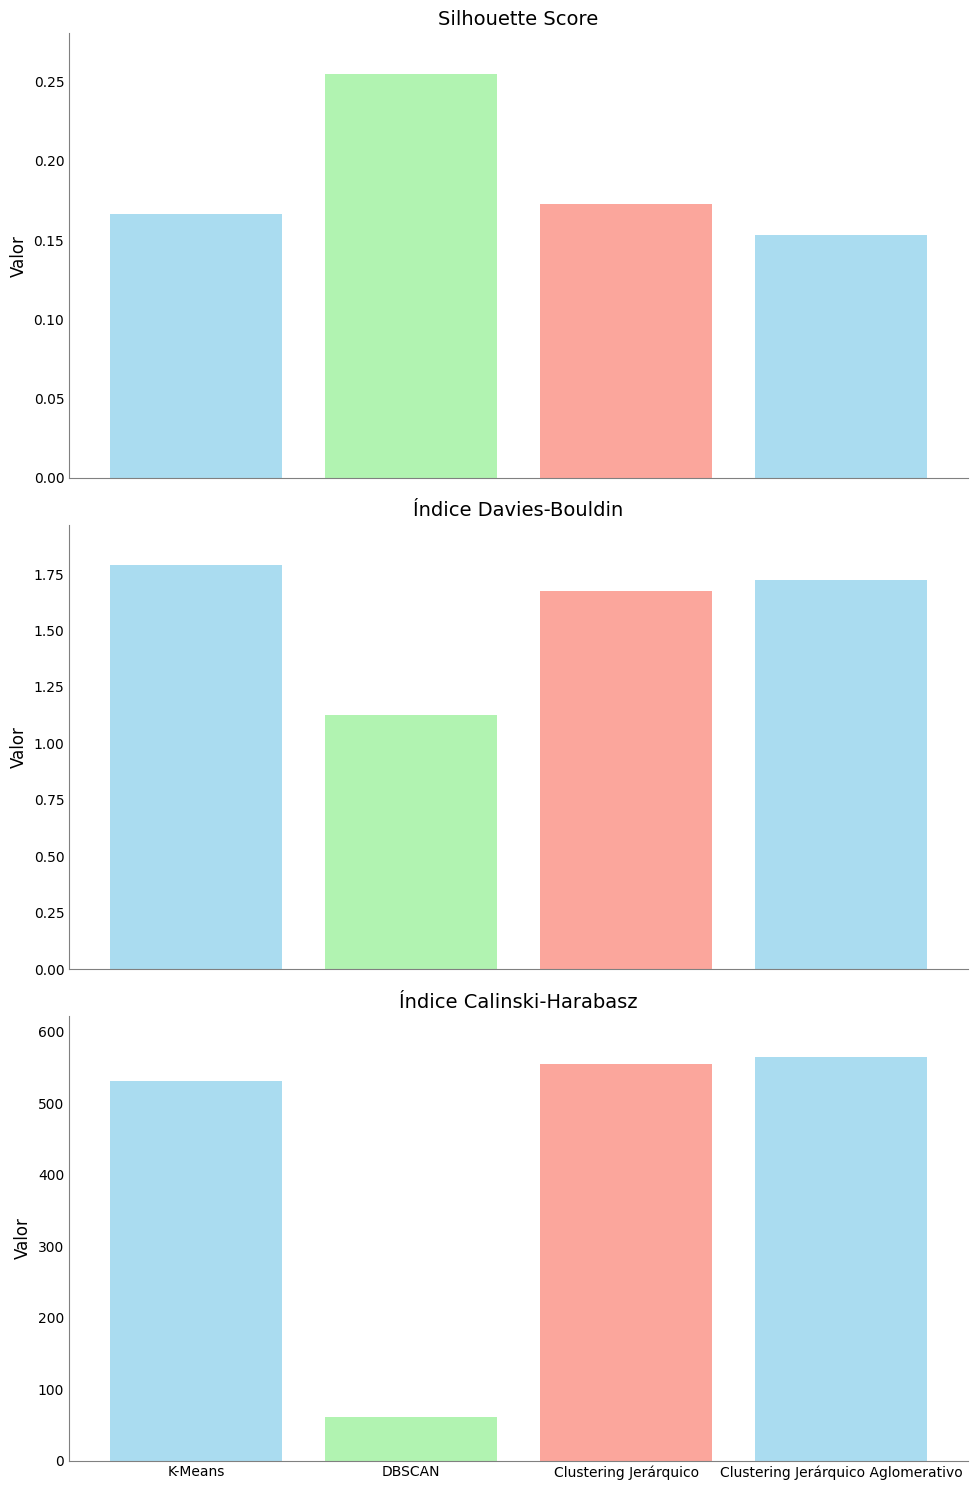

In [55]:
# Inicializar el diccionario con los nombres de las métricas como claves
metrics = {
    'Silhouette Score': [],
    'Índice Davies-Bouldin': [],
    'Índice Calinski-Harabasz': []
}

# Lista de etiquetas de clustering
labels_list = [kmeans_labels, dbscan_labels, hierarchical_labels, agglomerative_labels]

# Función para calcular las métricas de manera condicional para DBSCAN
def calculate_metrics(X, labels):
    if len(set(labels)) > 1:  # Válido para métricas
        return [
            silhouette_score(X, labels),
            davies_bouldin_score(X.toarray(), labels),
            calinski_harabasz_score(X.toarray(), labels)
        ]
    else:  # No aplicable si DBSCAN tiene menos de 2 clusters
        return ["No aplicable"] * 3

# Calcular y almacenar cada métrica para cada método de clustering
for labels in labels_list:
    results = calculate_metrics(X, labels)
    for metric_name, result in zip(metrics.keys(), results):
        metrics[metric_name].append(result)

# Nombres de las columnas para el DataFrame
column_names = ['K-Means', 'DBSCAN', 'Clustering Jerárquico', 'Clustering Jerárquico Aglomerativo']

# Crear DataFrame con las métricas como filas y los métodos como columnas
metrics_df = pd.DataFrame(metrics, index=column_names)

# Aplicar estilos al DataFrame
styled_df = metrics_df.style.background_gradient(cmap='coolwarm') \
                            .set_properties(**{'text-align': 'center', 'font-size': '12pt', 'color': 'black'}) \
                            .set_table_styles([{
                                'selector': 'th',
                                'props': [('font-size', '14pt'), ('background-color', 'lightgrey')]
                            }, {
                                'selector': 'td',
                                'props': [('background-color', 'white')]
                            }])

# Crear gráficos de las métricas
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
colors = ['skyblue', 'lightgreen', 'salmon']
for ax, (metric, values) in zip(axes, metrics.items()):
    values = [0 if v == "No aplicable" else v for v in values]
    bars = ax.bar(column_names, values, color=colors, alpha=0.7)
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel('Valor', fontsize=12)
    ax.set_ylim(0, max(values) + (0.1 * max(values)))  # Añadir más espacio arriba
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(False)  # Remove grid lines

plt.tight_layout()
plt.show()



In [56]:
# Mostrar la tabla
styled_df

,Silhouette Score,Índice Davies-Bouldin,Índice Calinski-Harabasz
K-Means,0.166143,1.789288,530.687838
DBSCAN,0.254842,1.127338,60.799303
Clustering Jerárquico,0.172808,1.673542,554.721452
Clustering Jerárquico Aglomerativo,0.153171,1.722449,565.499024


# Análisis comparativo

Al comparar el uso de TF-IDF y CountVectorizer en este dataset de logs asociados a la simulación de ataques, se observan diferencias significativas en las métricas evaluadas. TF-IDF consistentemente ofrece mejores valores de Silhouette Score en todos los métodos de clustering, lo que sugiere una mayor cohesión y definición dentro de los clusters. Sin embargo, el índice Calinski-Harabasz, que mide la separación entre los clusters respecto a la dispersión interna, muestra en general resultados superiores con CountVectorizer, especialmente en los métodos de clustering jerárquico.

El índice Davies-Bouldin, que evalúa tanto la dispersión interna de los clusters como su separación, presenta resultados mixtos, indicando que la elección entre TF-IDF y CountVectorizer podría depender específicamente del balance deseado entre compactación interna y separación entre clusters.

DBSCAN con TF-IDF destaca como la opción más equilibrada, proporcionando una buena combinación de cohesión y separación de clusters según se refleja en las métricas evaluadas. En contraste, el Clustering Jerárquico Aglomerativo tiende a beneficiarse más del uso de CountVectorizer en términos de maximizar la separación entre clusters, como lo indica el índice Calinski-Harabasz.

Por lo tanto, la elección del método de vectorización debe guiarse por los objetivos específicos del análisis de clustering, ponderando qué aspecto es más crítico para el contexto de aplicación: la cohesión interna de los clusters o su claridad y separación.